## Model Building

### Build model for predicting price of appartments

In [148]:
#import packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [149]:
#Read data
df = pd.read_csv('mubawab_listings_eda.csv')

In [150]:
df.head()

,Type,Localisation,Latitude,Longitude,Price,Area,Rooms,Bedrooms,Bathrooms,Floor,Other_tags,Price_m2,Current_state,Age
0,Appartements,Anfa,NaN,NaN,1230000,86.0,3.0,2.0,2.0,1.0,"['Bon état', '10-20 ans']",14302.325581,Bon état,10-20 ans
1,Appartements,La Gironde,NaN,NaN,900000,86.0,3.0,2.0,1.0,5.0,"['Bon état', '10-20 ans']",10465.116279,Bon état,10-20 ans
2,Appartements,Bourgogne Ouest,NaN,NaN,2400000,180.0,5.0,3.0,3.0,3.0,"['Bon état', '10-20 ans']",13333.333333,Bon état,10-20 ans
3,Appartements,Les princesses,33.574209,-7.644182,1550000,120.0,5.0,3.0,2.0,5.0,"['Bon état', '5-10 ans']",12916.666667,Bon état,5-10 ans
4,Appartements,Bourgogne Ouest,NaN,NaN,1450000,113.0,4.0,3.0,2.0,1.0,"['Bon état', '10-20 ans']",12831.858407,Bon état,10-20 ans


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           1250 non-null   object 
 1   Localisation   1250 non-null   object 
 2   Latitude       672 non-null    float64
 3   Longitude      672 non-null    float64
 4   Price          1250 non-null   int64  
 5   Area           1250 non-null   float64
 6   Rooms          1191 non-null   float64
 7   Bedrooms       1247 non-null   float64
 8   Bathrooms      1207 non-null   float64
 9   Floor          953 non-null    float64
 10  Other_tags     1250 non-null   object 
 11  Price_m2       1250 non-null   float64
 12  Current_state  1101 non-null   object 
 13  Age            715 non-null    object 
dtypes: float64(8), int64(1), object(5)
memory usage: 136.8+ KB


In [152]:
#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price']
df_model = df[cols_to_keep]

In [153]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

Localisation       0
Area               0
Rooms             17
Bedrooms           3
Bathrooms         10
Floor              0
Current_state     31
Age              105
Price              0
dtype: int64

In [154]:
#drop listings where one of the four continuous variables are missing
df_model = df_model.dropna(subset = ['Rooms','Bedrooms','Bathrooms','Floor']).reset_index(drop = True)

In [155]:
df_model.isna().sum()

Localisation      0
Area              0
Rooms             0
Bedrooms          0
Bathrooms         0
Floor             0
Current_state    11
Age              82
Price             0
dtype: int64

In [156]:
#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price'].values 

In [157]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [158]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [159]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler

In [160]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)

In [161]:
#Scale the features using robust_scaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)

In [162]:
#define function to evaluate linear models
def evaluate_linear_model(X_train,y_train,X_test,y_test,reg,grid = False):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error_train = np.sqrt(MSE(y_train,reg.predict(X_train)))
    RMSE_error = np.sqrt(MSE(y_test,y_pred))
    MAPE_train = np.median(MAPE(y_train,reg.predict(X_train),multioutput = 'raw_values'))
    MAPE_test = np.median(MAPE(y_test,y_pred, multioutput = 'raw_values'))
    
    if grid:
        print(f'Best estimator parameters : {reg.best_params_}')
        reg = reg.best_estimator_
        
    
    print(f'train RMSE : {RMSE_error_train:.2f}')
    print(f'test RMSE : {RMSE_error:.2f}')
    print(f'train MAPE : {MAPE_train:.4f}')
    print(f'test MAPE : {MAPE_test:.4f}')
    print(f'Training set score (R^2): {reg.score(X_train,y_train):.2f}')
    print(f'Test set score (R^2): {reg.score(X_test,y_test):.2f}')
    coef_matrix = pd.DataFrame(np.hstack([reg.intercept_,reg.coef_]).reshape(1,-1),columns = np.hstack(['Intercept',X_train.columns]))
    display(coef_matrix)
    
    error_matrix = np.array([y_test,(y_test-y_pred)/y_test])

    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = coef_matrix.columns,x = coef_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    

    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(x,'%')))
    #g = sns.jointplot(x = error_matrix[0,:], y= error_matrix[1,:],color = cust_pal[5], height = 8, ratio = 5)
    
    plt.tight_layout()
    plt.show()
    
cust_pal = sns.color_palette(sns.light_palette('#0d874b',10))

train RMSE : 3638103.61
test RMSE : 3107591.03
train MAPE : 0.1983
test MAPE : 0.2435
Training set score (R^2): 0.87
Test set score (R^2): 0.89


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Localisation_CIL (Hay Salam),Localisation_Californie,Localisation_Casablanca,Localisation_Gauthier,Localisation_Les princesses,Localisation_Longchamps (Hay Al Hanâa),Localisation_Oasis,Localisation_Oulfa,Localisation_Polo,Localisation_Sidi Maarouf
0,3.918498e+06,12347.593602,-149124.27158,-587510.543512,1.035062e+06,-4.656613e-10,-250614.217889,-299417.926294,894089.283739,-20714.155047,...,400590.476251,-1.911290e+06,-3.708698e+06,93049.143468,-2.637205e+06,2.667994e+06,-817896.076627,-3.891010e+06,-3.001220e+06,-2.391213e+06


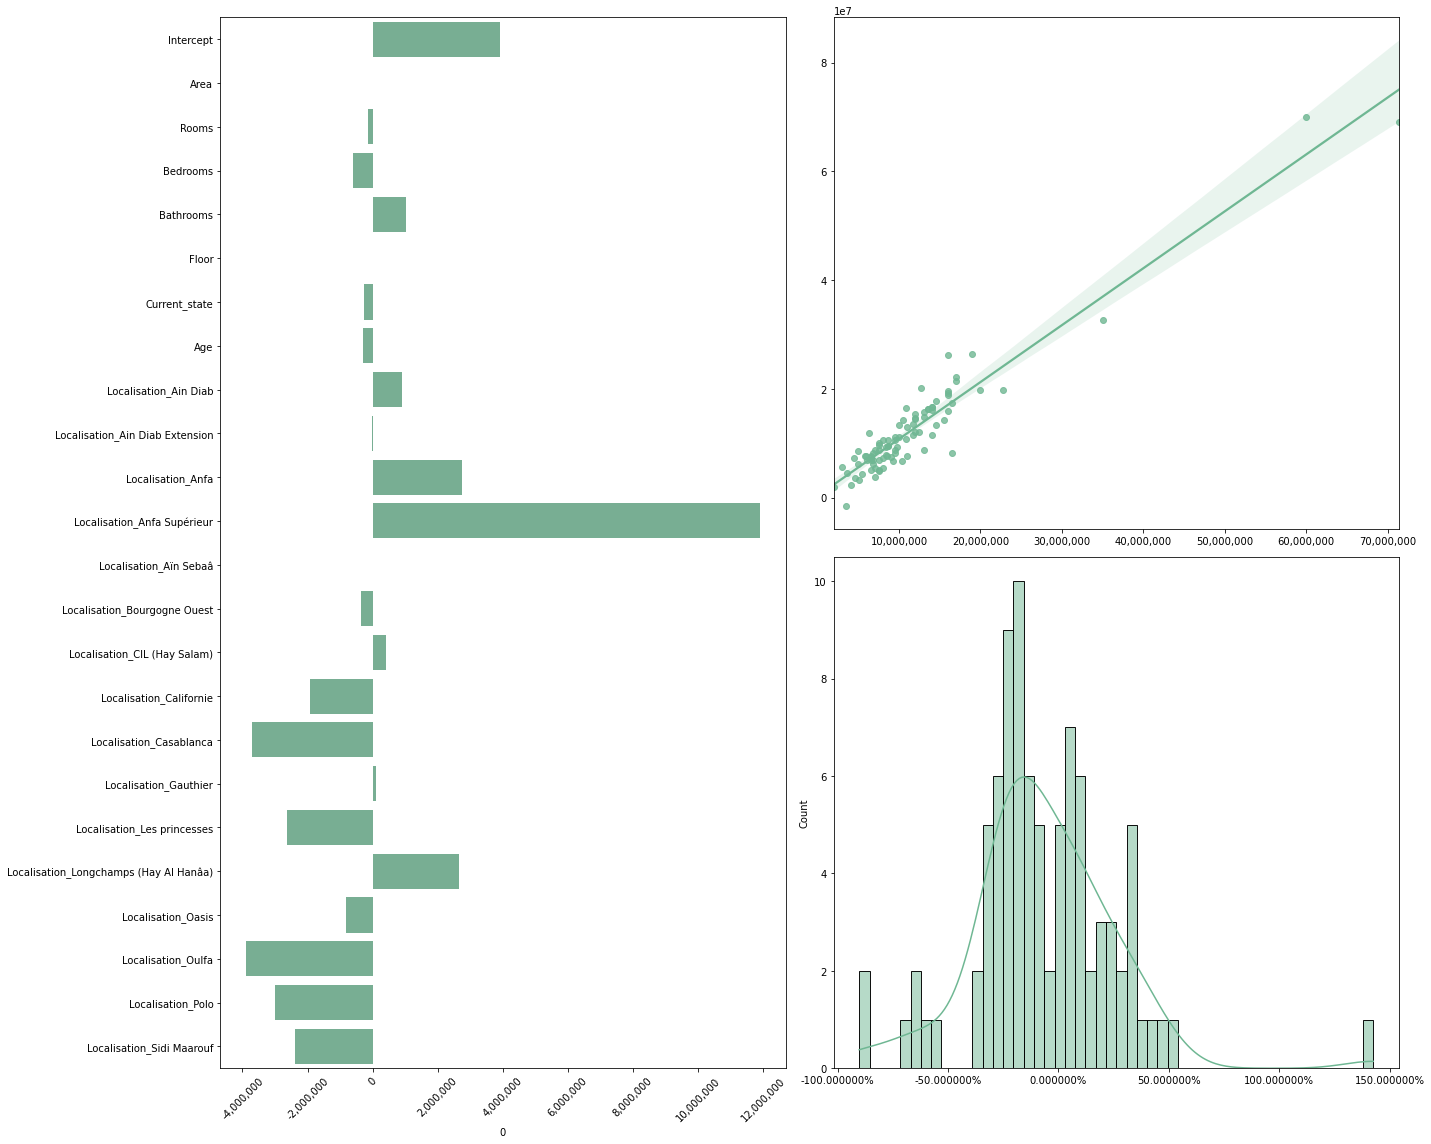

In [163]:
#Evaluate multivariate ols linear regression


linear_regression = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,linear_regression)

Best estimator parameters : {'alpha': 0.1}
train RMSE : 3638316.47
test RMSE : 3094995.55
train MAPE : 0.1980
test MAPE : 0.2422
Training set score (R^2): 0.87
Test set score (R^2): 0.89


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Localisation_CIL (Hay Salam),Localisation_Californie,Localisation_Casablanca,Localisation_Gauthier,Localisation_Les princesses,Localisation_Longchamps (Hay Al Hanâa),Localisation_Oasis,Localisation_Oulfa,Localisation_Polo,Localisation_Sidi Maarouf
0,3.954639e+06,12367.373463,-148451.928135,-589811.203243,1.030107e+06,0.0,-248847.477459,-299474.582217,860997.551064,-46035.110192,...,368457.210306,-1.943409e+06,-3.646821e+06,57406.17027,-2.421431e+06,2.610207e+06,-843609.020064,-3.727638e+06,-3.012838e+06,-2.397742e+06


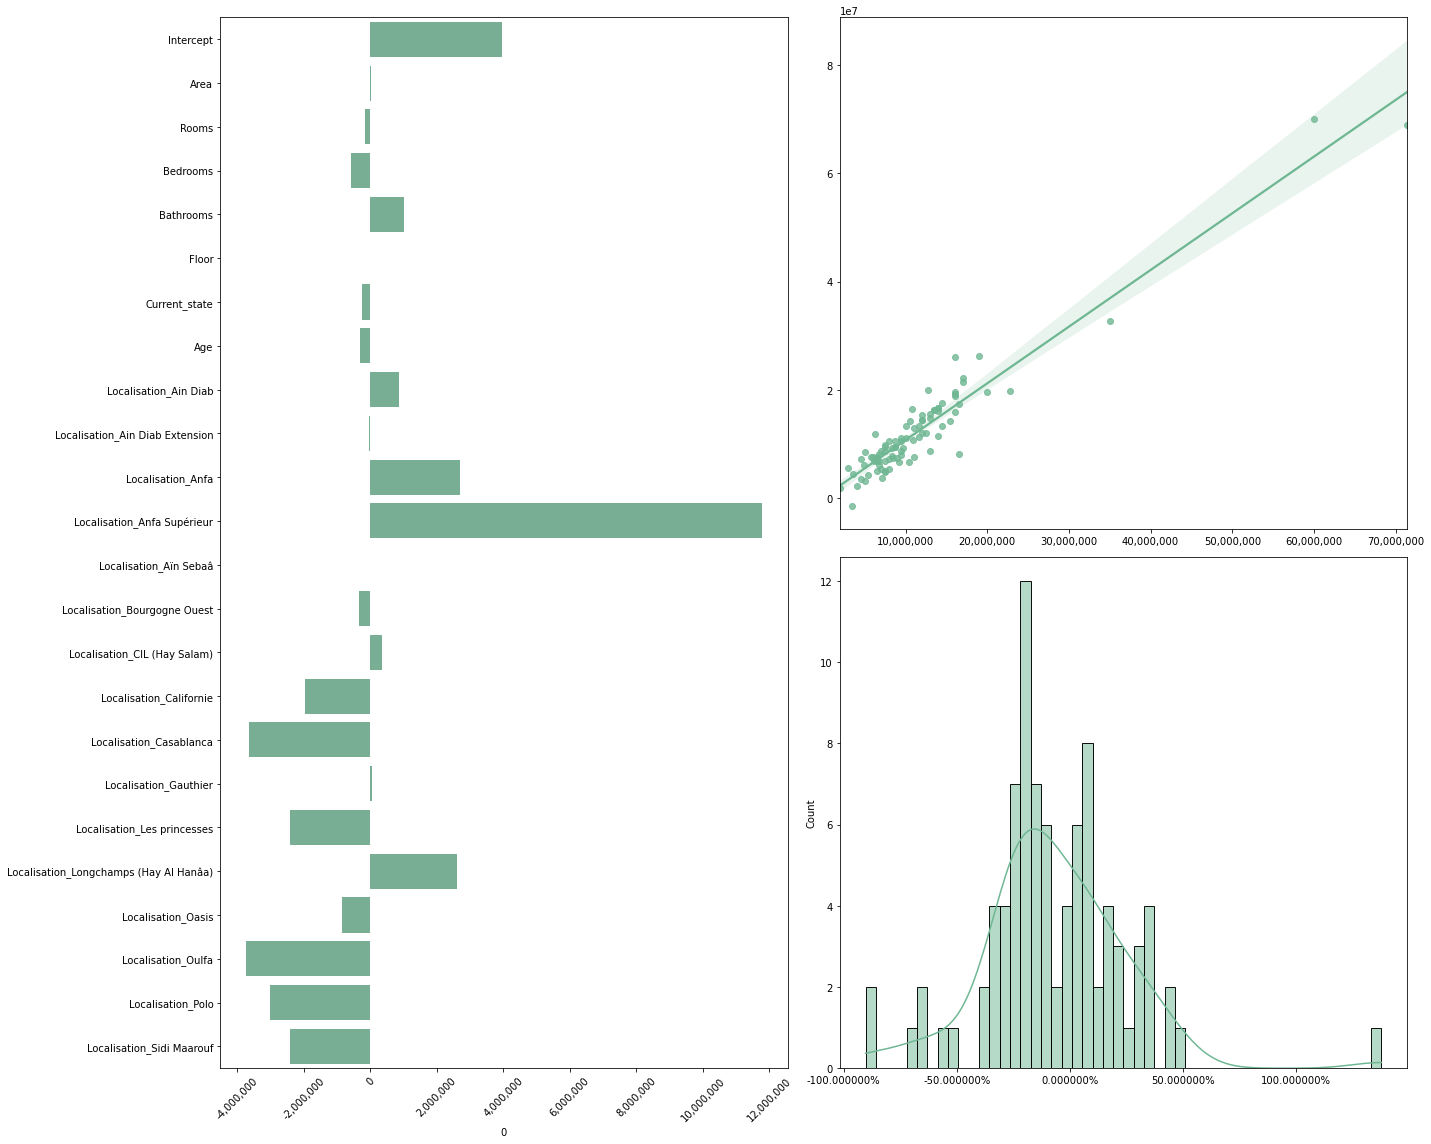

In [164]:
#Use a Ridge regression to introduce regularization
ridge = Ridge()
ridge_hyparams = {'alpha':[0.1,1,3,5]}
ridge_regression = GridSearchCV(ridge,ridge_hyparams,cv = 5)
evaluate_linear_model(X_train,y_train,X_test,y_test,ridge_regression,grid = True)

Best estimator parameters : {'alpha': 0.1}
train RMSE : 3638313.88
test RMSE : 3338313.89
train MAPE : 0.1981
test MAPE : 0.2577
Training set score (R^2): 0.87
Test set score (R^2): 0.88


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Localisation_CIL (Hay Salam),Localisation_Californie,Localisation_Casablanca,Localisation_Gauthier,Localisation_Les princesses,Localisation_Longchamps (Hay Al Hanâa),Localisation_Oasis,Localisation_Oulfa,Localisation_Polo,Localisation_Sidi Maarouf
0,1.001166e+07,7.465577e+06,-295804.25632,-589550.225482,1.031140e+06,0.0,-249671.632685,-1.193617e+06,755233.978985,-152616.157461,...,262633.056203,-1.024652e+06,-3.747628e+06,-37236.661017,-2.520442e+06,2.506054e+06,-947368.420807,-3.828156e+06,-3.116849e+06,-2.502980e+06


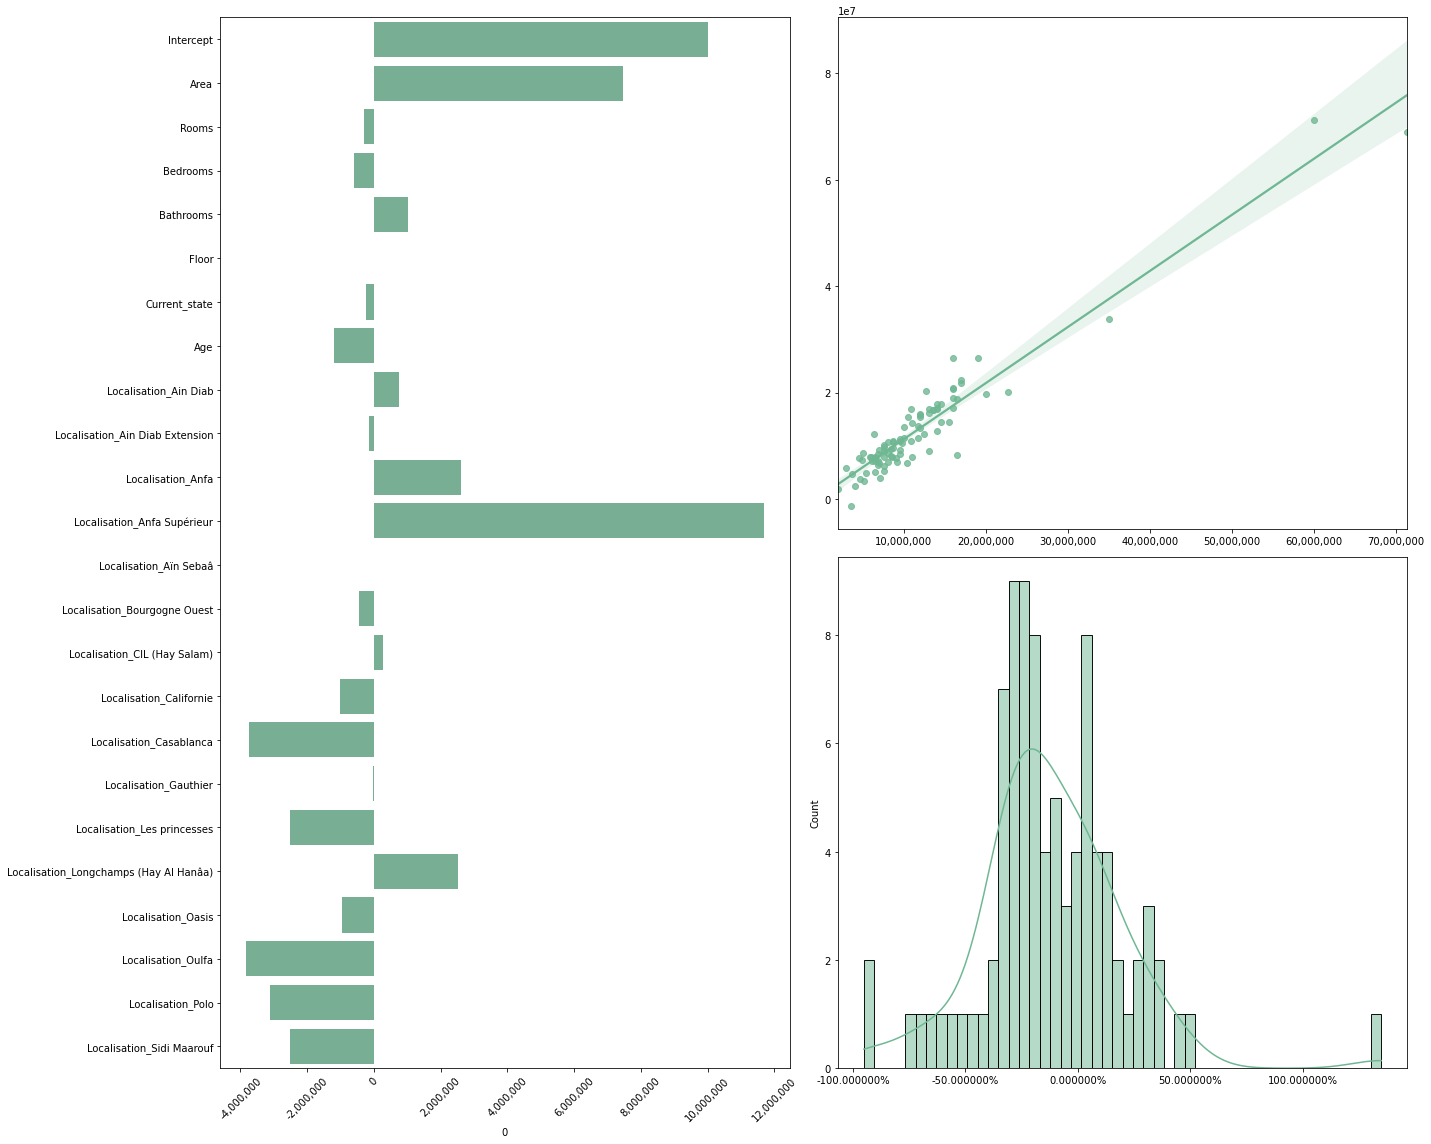

In [165]:
#Use a Ridge regression to introduce regularization with scaled data
evaluate_linear_model(X_train_scaled,y_train,X_test_scaled,y_test,ridge_regression,grid=True)

In [166]:
continuous_vars = ['Area','Rooms','Bedrooms','Bathrooms']

poly = PolynomialFeatures(degree = 2,include_bias = False)
poly = poly.fit(X[continuous_vars])
poly_df = pd.DataFrame(poly.transform(X[continuous_vars]),columns = poly.get_feature_names(continuous_vars))

In [167]:
X_poly = pd.concat([X_dummies,poly_df],axis=1)
X_poly.shape

(297, 37)

In [168]:
#split the data using the same random state for comparable results
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size = 0.3,random_state = 123)

In [169]:
scaler = RobustScaler()
X_train_poly_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly_scaled = pd.DataFrame(scaler.fit_transform(X_test_poly),columns = X_test_poly.columns)

train RMSE : 3092953.40
test RMSE : 3642228.62
train MAPE : 0.1961
test MAPE : 0.3038
Training set score (R^2): 0.91
Test set score (R^2): 0.85


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,1.026190e+07,6.563103e+06,-621043.0811,1.056950e+06,-1.633192e+06,-4.656613e-10,-370041.38475,-1.235318e+06,878078.951283,-190783.372646,...,-724912.037979,-591589.287891,-5.249891e+06,2.572391e+06,336903.223915,958805.847748,171895.181906,-2.515461e+06,1.772595e+06,2.042890e+06


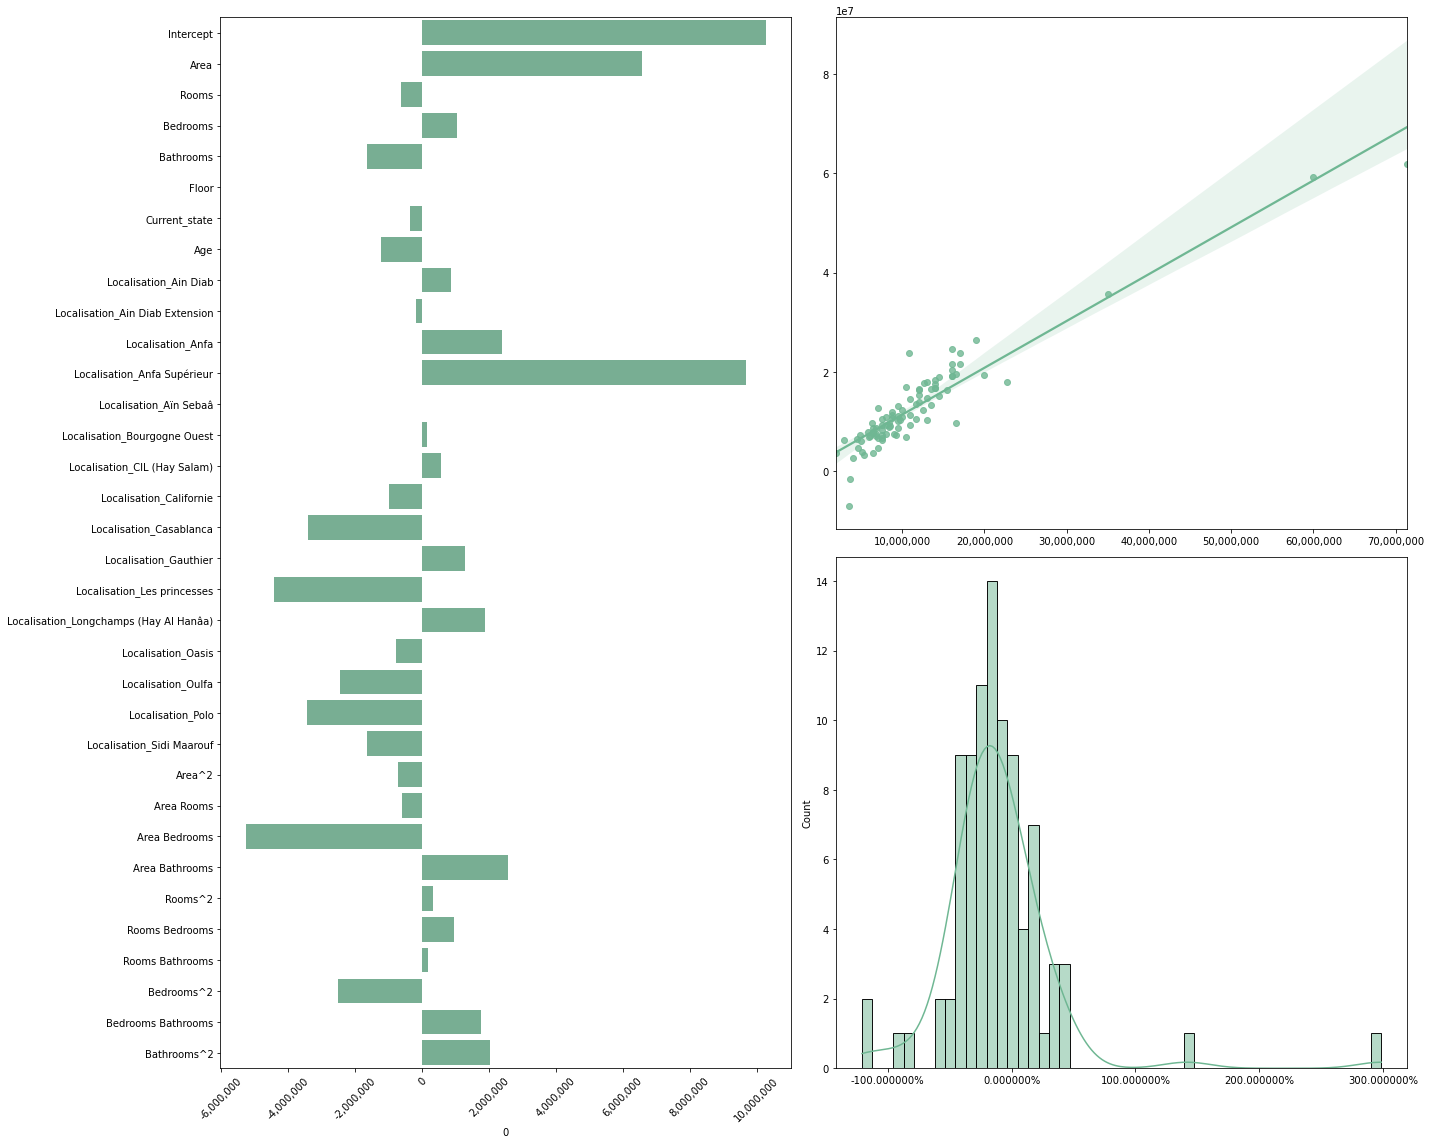

In [170]:
#Evaluate multivariate ols linear regression with polynomial features and feature scaling

poly_linear_regression = LinearRegression()
poly_linear_regression.fit(X_train_poly_scaled,y_train)

evaluate_linear_model(X_train_poly_scaled,y_train_poly,X_test_poly_scaled,y_test_poly,poly_linear_regression)

Best estimator parameters : {'alpha': 0.1}
train RMSE : 3093435.82
test RMSE : 3562669.56
train MAPE : 0.1960
test MAPE : 0.2939
Training set score (R^2): 0.91
Test set score (R^2): 0.86


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,1.023702e+07,6.528187e+06,-575958.941879,959036.803336,-1.604084e+06,0.0,-370257.492294,-1.241947e+06,843080.865264,-202754.412446,...,-734992.107798,-594499.162388,-5.084091e+06,2.491810e+06,347802.295001,816139.938371,196644.387263,-2.210224e+06,1.592931e+06,2.087942e+06


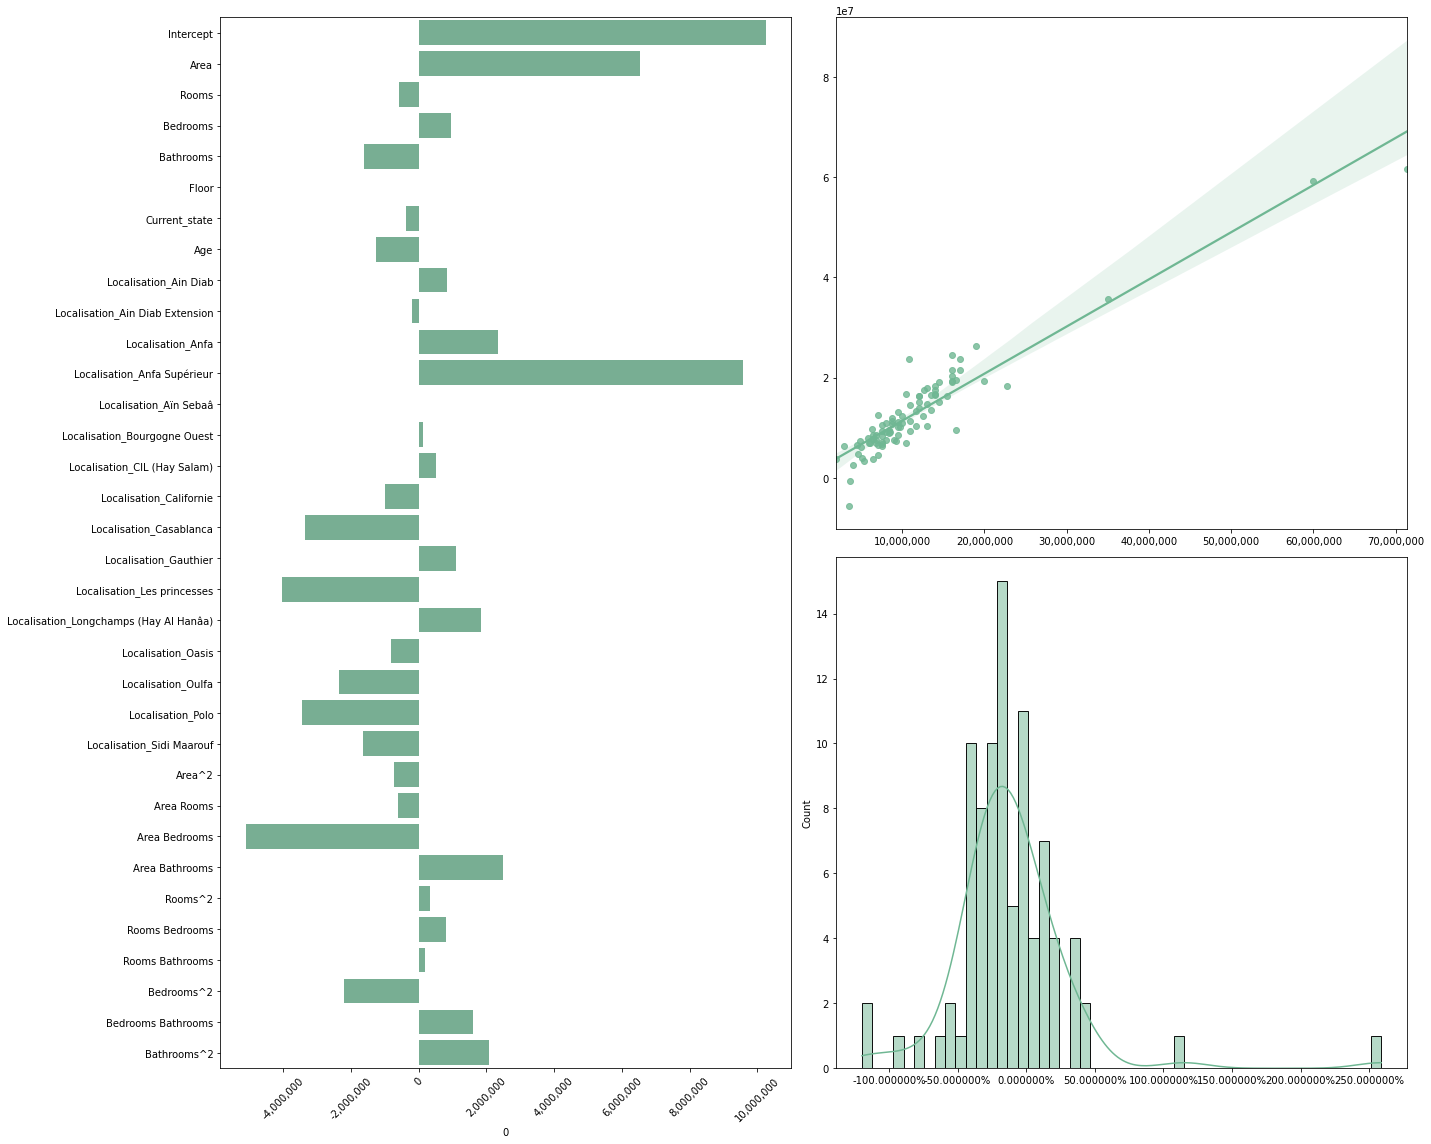

In [171]:
#Use a Ridge regression with polynomial features to introduce regularization with scaled data
ridge = Ridge()
ridge_hyparams = {'alpha':[0.001,0.01,0.1,1,3,5,10]}
poly_ridge_regression = GridSearchCV(ridge,ridge_hyparams,cv = 5)
evaluate_linear_model(X_train_poly_scaled,y_train,X_test_poly_scaled,y_test,poly_ridge_regression,grid=True)

In [172]:
def evaluate_tree_model(X_train,y_train,X_test,y_test,reg,grid=False):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error_train = np.sqrt(MSE(y_train,reg.predict(X_train)))
    RMSE_error = np.sqrt(MSE(y_test,y_pred))
    MAPE_train = np.median(MAPE(y_train,reg.predict(X_train),multioutput = 'raw_values'))
    MAPE_test = np.median(MAPE(y_test,y_pred, multioutput = 'raw_values'))
    
    if grid:
        print(f'Best estimator parameters : {reg.best_params_}')
        reg = reg.best_estimator_
        
    
    print(f'train RMSE : {RMSE_error_train:.2f}')
    print(f'test RMSE : {RMSE_error:.2f}')
    print(f'train MAPE : {MAPE_train:.4f}')
    print(f'test MAPE : {MAPE_test:.4f}')
    print(f'Training set score: {reg.score(X_train,y_train):.2f}')
    print(f'Test set score: {reg.score(X_test,y_test):.2f}')
    importances_matrix = pd.DataFrame(reg.feature_importances_.reshape(1,-1),columns = X_dummies.columns)
    display(importances_matrix)
    error_matrix = np.array([y_test,(y_test-y_pred)/y_test])
    
    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = importances_matrix.columns,x = importances_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    
    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(x,'%')))
    
    plt.tight_layout()
    plt.show()

In [173]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Best estimator parameters : {'max_depth': 10, 'n_estimators': 50}
train RMSE : 1765458.39
test RMSE : 4143380.14
train MAPE : 0.0850
test MAPE : 0.1882
Training set score: 0.97
Test set score: 0.81


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Localisation_Ain Diab,Localisation_Ain Diab Extension,Localisation_Anfa,...,Localisation_CIL (Hay Salam),Localisation_Californie,Localisation_Casablanca,Localisation_Gauthier,Localisation_Les princesses,Localisation_Longchamps (Hay Al Hanâa),Localisation_Oasis,Localisation_Oulfa,Localisation_Polo,Localisation_Sidi Maarouf
0,0.856595,0.020046,0.012844,0.024254,0.0,0.012793,0.015511,0.004383,0.001238,0.005392,...,0.000736,0.004452,0.000375,0.00003,0.000142,0.004844,0.000975,0.00053,0.005365,0.001872


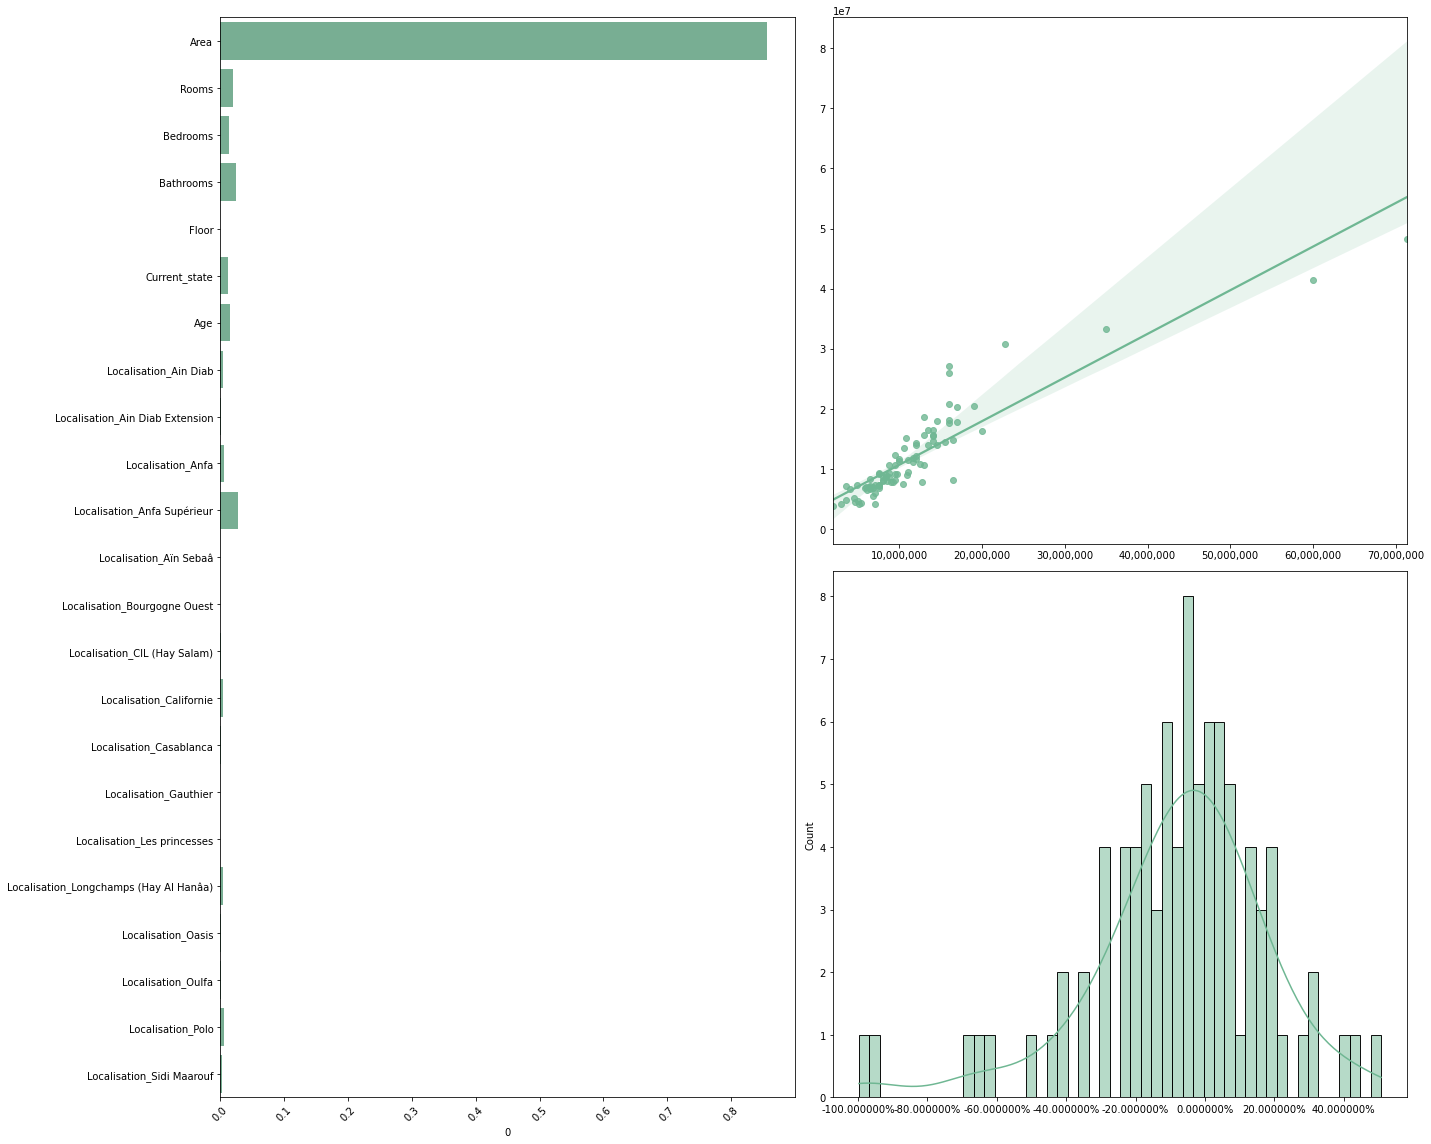

In [174]:
#Use a random forest regressor
rf = RandomForestRegressor()
rf_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [5,10]}
random_forest = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,random_forest,grid=True)

Best estimator parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
train RMSE : 885676.27
test RMSE : 3703843.35
train MAPE : 0.0665
test MAPE : 0.1889
Training set score: 0.99
Test set score: 0.85


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Localisation_Ain Diab,Localisation_Ain Diab Extension,Localisation_Anfa,...,Localisation_CIL (Hay Salam),Localisation_Californie,Localisation_Casablanca,Localisation_Gauthier,Localisation_Les princesses,Localisation_Longchamps (Hay Al Hanâa),Localisation_Oasis,Localisation_Oulfa,Localisation_Polo,Localisation_Sidi Maarouf
0,0.842056,0.013577,0.01017,0.035202,0.0,0.009988,0.008097,0.002653,0.0002,0.004924,...,0.000183,0.008954,0.000882,0.000045,0.000476,0.003008,0.000561,0.000546,0.00706,0.002326


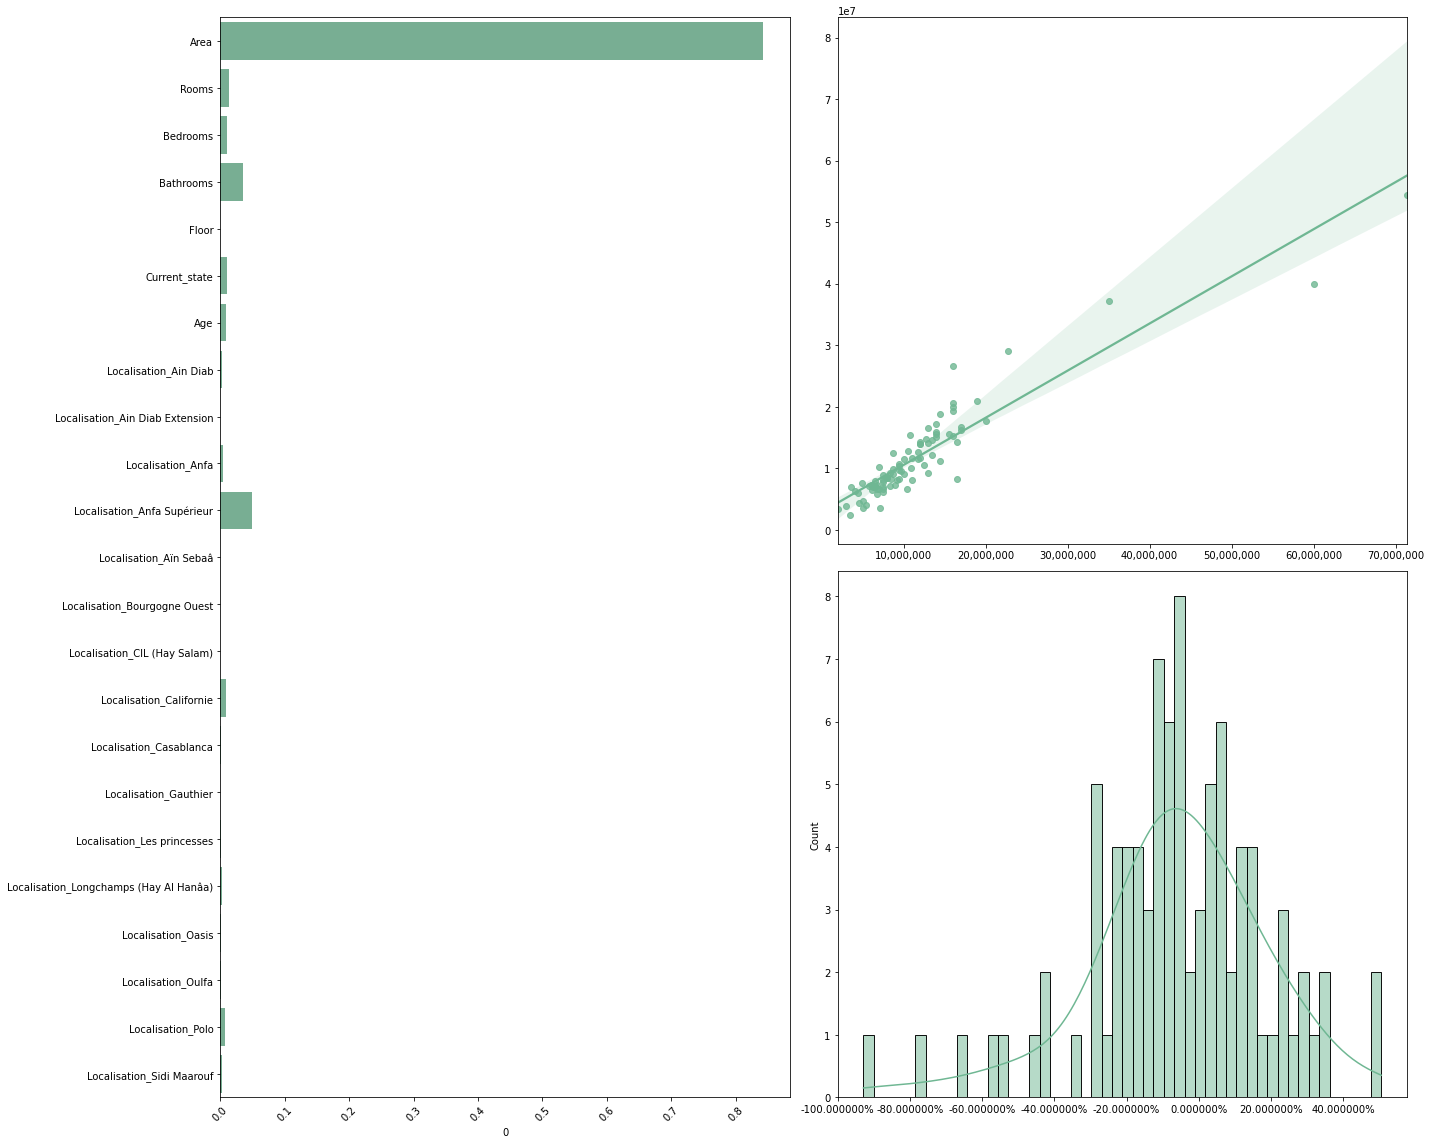

In [175]:
#Use a gradient boosting regressor
rf = GradientBoostingRegressor()
rf_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [3,5,10,15],'learning_rate':[0.05,0.1,0.5]}
gradient_boosted_regressor = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,gradient_boosted_regressor,grid=True)

### Build model for predicting Price_m2 

In [ ]:
#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price_m2']
df_model = df[cols_to_keep]

In [ ]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

In [ ]:
#drop listings where all four continuous variables are missing
df_model = df_model.dropna(subset = ['Rooms','Bedrooms','Bathrooms','Floor']).reset_index(drop = True)

In [ ]:
#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price_m2'].values 

In [ ]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)

In [ ]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [ ]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
#Evaluate multivariate ols linear regression


reg = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,reg)

In [ ]:
#Introduce polynomial features


In [ ]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [ ]:
X_poly = pd.concat([X_dummies,poly_df],axis=1)
X_poly.shape

In [ ]:
#split the data using the same random state for comparable results
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size = 0.3,random_state = 123)

In [ ]:
scaler = RobustScaler()
X_train_poly_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly_scaled = pd.DataFrame(scaler.fit_transform(X_test_poly),columns = X_test_poly.columns)

X_train_poly_scaled

In [ ]:
#Evaluate multivariate ols linear regression with polynomial features and feature scaling

reg = LinearRegression()
reg.fit(X_train_poly_scaled,y_train)

evaluate_linear_model(X_train_poly_scaled,y_train_poly,X_test_poly_scaled,y_test_poly,reg)

In [ ]:
#Use a random forest regressor
rf = RandomForestRegressor()
rf_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [5,10],'max_features':[10]}
reg = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,reg,grid=True)